In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import os
import scipy
import cv2
%matplotlib inline
sns.set_style('white')

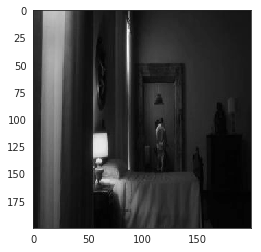

In [152]:
test_img = 'test_images/img2.jpg'

img = Image.open(test_img).convert('L').resize((200, 200))

nimg = np.array(img)

plt.imshow(nimg, cmap='gray', vmin=0, vmax=256)
plt.show()

In [214]:
def _binary_array_to_hex(arr):
	"""
	internal function to make a hex string out of a binary array.
	"""
	bit_string = ''.join(str(b) for b in 1 * arr.flatten())
	width = int(np.ceil(len(bit_string)/4))
	return '{:0>{width}x}'.format(int(bit_string, 2), width=width)

class ImageHash(object):
	"""
	Hash encapsulation. Can be used for dictionary keys and comparisons.
	"""
	def __init__(self, binary_array):
		self.hash = binary_array

	def __str__(self):
		return _binary_array_to_hex(self.hash.flatten())

	def __repr__(self):
		return repr(self.hash)

	def __sub__(self, other):
		if other is None:
			raise TypeError('Other hash must not be None.')
		if self.hash.size != other.hash.size:
			raise TypeError('ImageHashes must be of the same shape.', self.hash.shape, other.hash.shape)
		return np.count_nonzero(self.hash.flatten() != other.hash.flatten())

	def __eq__(self, other):
		if other is None:
			return False
		return np.array_equal(self.hash.flatten(), other.hash.flatten())

	def __ne__(self, other):
		if other is None:
			return False
		return not np.array_equal(self.hash.flatten(), other.hash.flatten())

	def __hash__(self):
		# this returns a 8 bit integer, intentionally shortening the information
		return sum([2**(i % 8) for i, v in enumerate(self.hash.flatten()) if v])
    
def average_hash(image, hash_size=8):
	"""
	Average Hash computation
	Implementation follows http://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html
	Step by step explanation: https://www.safaribooksonline.com/blog/2013/11/26/image-hashing-with-python/
	@image must be a PIL instance.
	"""
	if hash_size < 2:
		raise ValueError("Hash size must be greater than or equal to 2")

	# reduce size and complexity, then covert to grayscale
	image = image.convert("L").resize((hash_size, hash_size), Image.ANTIALIAS)

	# find average pixel value; 'pixels' is an array of the pixel values, ranging from 0 (black) to 255 (white)
	pixels = np.asarray(image)
	avg = pixels.mean()

	# create string of bits
	diff = pixels > avg
	# make a hash
	return ImageHash(diff)

In [215]:
average_hash(img).hash.flatten()

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])

In [216]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

blockshaped(np.array([[1, 2, 3, 0], [4, 5, 6, 0], [7, 8, 9, 0], [10, 11, 12, 0]]), 2, 2)

array([[[ 1,  2],
        [ 4,  5]],

       [[ 3,  0],
        [ 6,  0]],

       [[ 7,  8],
        [10, 11]],

       [[ 9,  0],
        [12,  0]]])

In [533]:
def rHash(image, hash_size=64):# words=12, bits=9):
    image = np.asarray(image)
    binarized = np.zeros(image.shape)
    fingerprint = np.zeros(hash_size)    
    
    n_blocks_w = np.sqrt(hash_size)
    n_blocks_h = np.sqrt(hash_size)
    
    block_width = int(len(image)//n_blocks_w)
    block_height = int(len(image)//n_blocks_h)
    
    assert image.shape[0] % n_blocks_w == 0
    assert image.shape[1] % n_blocks_h == 0
    
    block_means = []
    for i in range(0, len(image), block_height):
        for j in range(0, image.shape[1], block_width):
            mean = np.mean(image[i:i+block_height,j:j+block_width])
            block_means.append(mean)
    fingerprint = np.array(block_means) >= np.median(block_means)
    return fingerprint

def quandrant_rHash(image, hash_size=64):
    image = np.asarray(image)
    mid_x = len(image) // 2
    mid_y = image.shape[1] // 2

    hsize = hash_size // 4
    fingerprints = []
    fingerprints.append(rHash(image[0:mid_x,0:mid_y],  hsize))
    fingerprints.append(rHash(image[mid_x:,0:mid_y],  hsize))
    fingerprints.append(rHash(image[0:mid_x,mid_y:],  hsize))
    fingerprints.append(rHash(image[mid_x:,mid_y:],  hsize))
    return np.hstack(fingerprints)

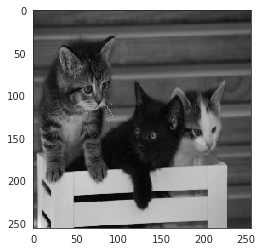

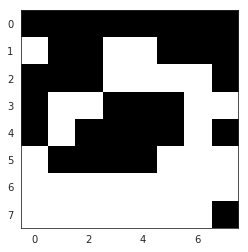

In [534]:
img = Image.open('test_images/cats_grey.jpg').convert('L').resize((256, 256))
plt.imshow(img, vmin=0, vmax=256, cmap='gray')
plt.show()
plt.imshow(rHash(img).reshape((8, 8)), vmin=0, vmax=1, cmap='gray')
plt.show()

In [535]:
IMAGES_DIR = 'test_images'

In [536]:
fnames = [os.path.join(IMAGES_DIR, fname) for fname in os.listdir(IMAGES_DIR)]
imnames = [fname for fname in os.listdir(IMAGES_DIR)]
images = [ cv2.imread(fname) for fname in fnames]
pil_images = [ Image.fromarray(img).convert('L').resize((256, 256)) for img in images]

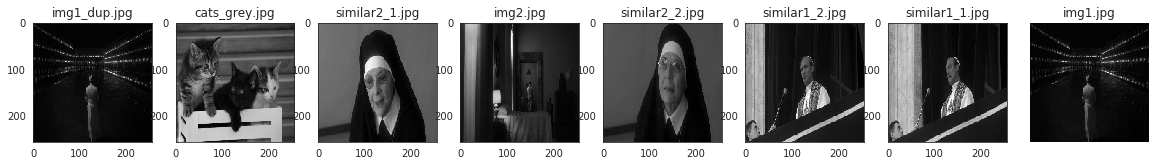

In [537]:
plt.figure(figsize=(20, 10))
i = 0
for img in pil_images:
    plt.subplot(1, len(images), i+1)
    plt.title(imnames[i])
    plt.imshow(img, cmap='gray')
    i+=1
plt.axis('off')
plt.show()

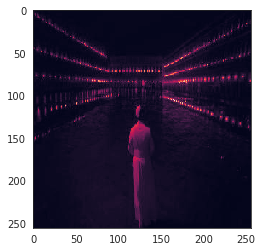

In [538]:
plt.imshow(pil_images[0])
plt.show()

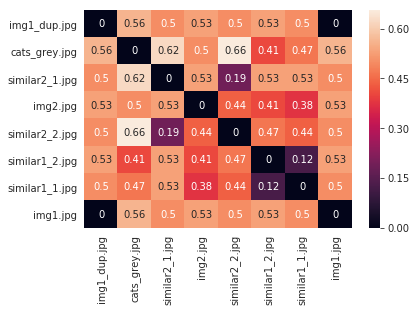

In [539]:
hashes = [rHash(img) for img in pil_images]
distances = scipy.spatial.distance.cdist(hashes, hashes, metric='hamming')   
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)

In [540]:
fingerprint = hashes[0]

word_length = 8
n_words = len(fingerprint) // word_length
n_words

8

In [541]:
lut = {}
print('Expected LUT dimension {} x {}'.format(n_words, 2**word_length))

Expected LUT dimension 8 x 256


In [532]:
def get_hash_value(id, ts):
    return id * 2**18 + ts
